# CSCI 410/1411 Homework 8: Tabular Reinforcement Learning

## Assignment Overview

Welcome to Homework 8!

This week, you will be writing code to play Blackjack, a two-player card game with inherent stochasticity, since you never know what card will be dealt next. If you've been to a casino, you know that Blackjack is played between a gambler, called the player, and a dealer, or the "house". The player's strategy is unrestricted; but the dealer is confined to play according a known strategy. As a result, the dealer is not really an adversarial agent, so the player should not optimize by searching for a minimax strategy (or, more precisely, an expected minimax strategy, since the environment is stochastic). Instead, the dealer's (fixed) behavior can be incorporated into the environment. From this point of view, a gambler should not view Blackjack as a game, but rather as a sequential decision process: i.e., a stochastic process that transitions randomly from state to state, for which he seeks an optimal action at each state. Indeed, in this assignment, you will model Blackjack as a *Markov* decision process.

## Learning Objectives

What you will know:
- what a Markov decision process (MDP) is
- how to formulate a sequential decision problem as a *tabular* MDP

What you will be able to do:
- run Monte Carlo simulations to estimate a policy's value
- solve tabular MDPs for their optimal policies using two different algorithms:
  - value iteration
  - $Q$-learning

## The Game of Blackjack

Blackjack is a popular card game played at casinos between a player and the card dealer. The player's goal is to be dealt cards that total closer to 21 than the dealer's--without going over.

#### Card Values

Each card has a specific worth, which contributes to a hand's total value: 
- **Numerical Cards (2-10)**: Each card is worth its face value.
- **Face Cards (Jack, Queen, King)**: Each of these cards is worth 10.
- **Aces**: Can count as either 11 or 1, whichever is more favorable to the hand. When an ace is counted as 11, it is called a "usable ace."

#### Gameplay

Here’s how a typical game of Blackjack unfolds:
1. **Initial Deal**: The dealer starts the game by dealing two cards to the player (face up) and two cards to herself, one face up and one face down.

2. **Player Decisions**:
   - **Stand**: The player keeps his current hand at its current total value.
   - **Hit**: The player requests an additional card to try to get closer to a total value of 21.
If ever the player's total exceeds 21, the player *busts*, and the game ends.

3. **Dealer's Play**: Once the player sticks (assuming he did not bust), the dealer reveals her face-down card. The dealer continues to draw cards until her total value reaches 17 or more.

4. **Conclusion**:
   - **Player Busts**: If the player's total exceeds 21, the dealer wins.
   - **Dealer Busts**: If the dealer's total exceeds 21, the player wins.
   - **Compare Totals**: If neither busts, the outcome of the game (win, lose, draw) is based on whose total is closer to 21.

## Blackjack as a Markov Decision Process

A [Markov Decision Process](https://en.wikipedia.org/wiki/Markov_decision_process) (MDP) is a model of sequential decision making under uncertainty.

An MDP comprises:
- a set of possible states $S$
- a set of possible actions $A$
- a transition function $P(s, a, s')$, which returns the probability of transitioning to state $s'$ from state $s$ upon taking action $a$
- a reward function $R(s, a)$, which returns the reward for taking action $a$ in state $s$
- an initial state distribution $\mu$
- a discount factor $\gamma$

The modifier "Markov" (besides referring to the Russian mathematician Andrey Markov) means that the current state alone contains all information relevant to predicting the next state. No additional historic information would shed any further light on the situation. "Given the present, the future is independent of the past."

A policy in an MDP is likewise a mapping from the current state (only) to an action. The goal of an agent who finds itself in a world modeled as an MDP is to find an **optimal** policy, meaning a policy that maximizes its long-term rewards. (Note that greedily choosing an action that maximizes immediate rewards at a state might not yield the greatest long-term rewards.)

#### Modelling Blackjack as an MDP

The first and most important step to solving any problem in AI is deciding how to represent your problem. We already gave you a big hint: you are going to model Blackjack as an MDP! But even with that information, there is work to be done.

To model a problem as an MDP, you need to define the *states* of the process. These states must contain enough information to make the process Markovian. On the other hand, MDPs with larger state spaces are harder to solve than MDPs with smaller ones.

**N.B.** This week's homework assignment is concerned with solving MDPs with **tabular** representations, meaning all the state values and $Q$-values can be stored in a table in a computer's memory. (So we will have to make sure the state space we choose for our Blackjack MDP is sufficiently small.) Next week's homework assignment will take us beyond tabular representations.

Before moving on, take some time to brainstorm about ways to represent states in Blackjack. What information should you include? What information can you do without?

After pondering this question for awhile, read on. We'll walk you through three possible options for representing Blackjack states.

#### State Representation #1: Player/Dealer Totals

The outcome of a game of Blackjack depends on the total value of the player's and the dealer's cards. The player knows the total value of his cards, so he can use this information to make a decision about how to play. If his cards add up to 20, for example, he probably shouldn't hit, as there is only one card he can draw that wouldn't cause him to bust. If his cards add up to 10, on the other hand, he should hit, as no card would increase his total without surpassing 21. So, as a first attempt, let's consider the player's total value as the state for our Blackjack MDP.

The lowest total value the player can encounter is $3$, if he is dealt a two and an ace. The highest total value is $30$, if he hits with 20 and is dealt a face card.

- $S = \{(p, d)\}$ for $p \in \{3, 4, ..., 30\}$
- $A = \{\textrm{hit}, \textrm{stand}\}$
- Transition Function: To calculate these probabilities, you would need to reason about the probability of each card value being drawn from the deck, given the cards drawn so far. (This calculation is complicated by the fact that the state encodes sums, not individual cards.)
- Reward Function:

    $R(p, d) = 1$
    - if the state is terminal ($d > 16$ or $p > 21$)
    - **and** the player doesn't bust ($p \leq 21$)
    - **and** either the dealer busts ($d>21$) or the player outscores the dealer $(p > d)$

    $R(p, d) = -1$
    - if the player busts $(p > 21)$
    - **or** if the dealer outscores the player (without busting) $(p < d \leq 21)$

    $R(p, d) = 0$
    - If neither the player nor dealer busts, and if they both have the same total value $(p = d \leq 21)$

Is this MDP formulation sufficient? Does it encode all the information you need to play blackjack well?

Try to answer this question before reading on.


#### State Representation #2: Adding the Usable Ace

Recall that an ace in Blackjack can count either as a 1 or an 11. As a result, keeping track of the player's total alone is not sufficient. For example, if the player's total is 15, it is important to know whether he has a useable ace or not. With a useable ace, it is probably a good idea to hit, since he can increase his total value with a 2, 3, 4, 5, or 6, and he doesn't run the risk of busting, since he could always resort back to having had only 5. On the other hand, if he doesn't have a usable ace, then whether or not he chooses to hit actually depends on one other important aspect of the game that we had also better include in the state. What is it?


#### State Representation #3: Adding the Dealer's Visible Card

The dealer's visible card is important because the dealer is more likely to bust with some visible cards than others. These probabilities are shown below:

| Dealer Card | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | Ace |
|------------|---|---|---|---|---|---|---|---|----|----|
| Bust % | 35% | 37% | 40% | 42% | 42% | 26% | 24% | 23% | 23% | 17% |

When the dealer is more likely to bust, the player should act more conservatively. Similarly, he should play more aggressively when the dealer is less likely to bust, so when the dealer's visible card is an ace, for example.

The state space of our Blackjack MDP is thus: $S = \{(p, d, v, u)\}$, for $p \in \{ 4, 5, \ldots, 30 \}$, $v \in \{ 1, \ldots, 10 \}$, and $u \in \{ 0, 1 \}$.


#### Markov Property

Reflect on our state space. Is the Blackjack MDP as we have defined it Markov? That is, does the current state contain all the requisite information to determine the next state? Why or why not?

The answer to this question is no. We have defined states to track the *total* value of the player's cards, but not their individual values. As a result, the state does not contain enough information to compute the probabilities over the various card values that might be dealt in the future.

There are two possible fixes to this problem. The first is to track individual card values in the states, instead of just their total. The difficulty with this approach is the ensuing size of the state space. Moreover, it is debatable whether this degree of precision is really required to play a stochastic game like Blackjack well.

An alternative approach, which we adopt in this assignment, is to assume cards are drawn with replacement. Or equivalently, we assume an infinite deck. This assumption simplifies the calculation of the transition probabilities substantially, and makes it possible for you to implement value iteration, which relies on these probabilities explicitly.

## The Blackjack Environment

We will be using the [gymnasium](https://gymnasium.farama.org/) library (abbreviated Gym) in this assignment.

Gym was built to facilitate research on reinforcement learning (RL) algorithms. It simulates myriad environments--modeled as Markov decision processes--and thereby enables AI researchers to experiment with the latest and the greatest RL algorithms on established benchmarks.

You will not be interacting with Gym directly. Instead, you will be interacting with a `Blackjack` class that we wrote for you, which extends an `MDP`, which inherits from Gym. The `Blackjack` and `MDP` classes are defined in `mdp.py`.

Here are some of the more relevant functions to this assignment:

`gym.make`: Initializes our Gym environment. This object is passed into the `Blackjack` constructor.

`mdp.reset`: Resets the environment to a new start state. The Blackjack start state is random, as it depends on the cards dealt.

`mdp.step`: Takes a "step" in the environment. This means starting off at a state $s$, taking an action $a$, and returning the next state $s'$. In Blackjack, the player can choose to hit or stand. After making his choice, his hand or the dealer's hand changes.

`mdp.get_transition_prob`: Given a state and an action taken in that state, gets the next possible states in our environment and their corresponding probabilities. For example, given the dealer's card, the player's hand, and the usable ace bit, if the player chooses to hit, this function will return all the possible next states that can arise when the player gets another card. It also the probability of entering each of these states.

`mdp.get_reward`: Returns the reward associated with a state. For example, if the player busts by going over 21, he loses the game, so his reward is $-1$. In our environment, a player either receives $+1$ for winning, $-1$ for losing, or 0 if the game is a draw.

Run the code cell below to setup your notebook.

In [46]:
from IPython.display import display
import PIL.Image
import matplotlib.pyplot as plt

import numpy as np
import gymnasium as gym
from typing import List, Dict, Tuple, Optional
import itertools
import math
import time

from mdp import Blackjack, BlackjackState, BlackjackAction, BlackjackPolicy
from utils import render_gym_blackjack_env, Q_table_to_policy, plot_value_function, plot_policy, plot_observation_count, plot_policy_with_observation

#### Initial States

Run the code below to see an example of an initial state. Run it several times to see several examples!

As outlined above, the state comprises the dealer's visible card, the player's total value, and a bit indicating whether the player has a usable ace or not. If you do not see "usable ace" depicted as part of the state, the player does not have a usable ace.

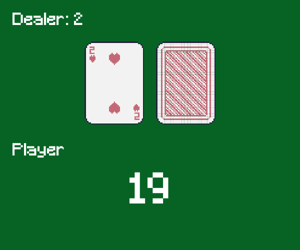

In [47]:
env = gym.make('Blackjack-v1', render_mode='rgb_array') # initializes the Blackjack environment in Gymnasium
state = env.reset() # resets the environment to the starting state (dealing hands to the player and dealer)
rgb_array = env.render() # load in the environment as an rgb array
image = PIL.Image.fromarray(rgb_array)
image = image.resize((image.width // 2, image.height // 2))
image.save('blackjack.png')
display(image) # display the image for our notebook from our modified rgb array
env.close()

#### Gameplay

Run the code below to watch a simulation of a game of Blackjack.

**N.B.** You can alter the parameter to `time.sleep()` line to speed up / slow down the game.

Initial State:


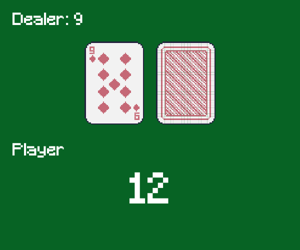

Player Total: 12, Dealer's Card: 9, Usable Ace: 0
Action taken: Hit


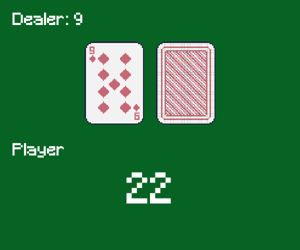

Player Total: 22, Dealer's Card: 9, Usable Ace: 0
Final State:


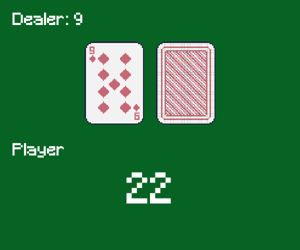

Player Total: 22, Dealer's Card: 9, Usable Ace: 0
Player loses.
Reward: -1.0


In [48]:
env = gym.make('Blackjack-v1', render_mode='rgb_array')

def play_blackjack() -> None:
    """
    Simulate a round of Blackjack with a simple naive policy.
    
    This demonstration function initializes the environment and follows a basic strategy:
    - Hit if player total < 20
    - Stand if player total >= 20
    
    The function renders each step and displays the final outcome.
    """
    # Setting up our environment and starting state
    state = env.reset()[0]
    print("Initial State:")
    render_gym_blackjack_env(env, state)
    time.sleep(1)

    # running the game until the player or dealer busts
    done = False
    while not done:
        # Naive policy: stand if 20 or higher, otherwise hit
        action = 0 if state[0] >= 20 else 1
        state, reward, done, info, _ = env.step(action)
        action_str = 'Stand' if action == 0 else 'Hit'
        print(f"Action taken: {action_str}")
        render_gym_blackjack_env(env, state)
        
        time.sleep(5) # Feel free to modify this value to slow down / speed up the game
        
    # displaying the final state and rewards
    print("Final State:")
    render_gym_blackjack_env(env, state)

    if reward > 0:
        print("Player wins!")
        print(f"Reward: {reward}")
    elif reward < 0:
        print("Player loses.")
        print(f"Reward: {reward}")
    else:
        print("It's a draw.")
        print(f"Reward: {reward}")

play_blackjack()

### Data Structures

The code below is excerpted from `mdp.py`. It describes how we represent the key components of the Blackjack MDP and its solution: e.g., the states, the actions, the policies, etc. Be sure you understand these data structures before proceeding, since you will not be able to correctly compute with the data they store otherwise.

In [49]:
BlackjackState = Tuple[int, int, int] # player hand total, dealer's card value, either 0 or 1 depending on the presence of a usable ace
BlackjackAction = int # either 0 to stand or 1 to hit
BlackjackPolicy = Dict[BlackjackState, BlackjackAction] # mapping each state to an action

ValueFunction = Dict[BlackjackState, float] # for Part 3, a table that maps each state to a value

QTable = Dict[Tuple[BlackjackState, BlackjackAction], float] # for Part 4, a table that maps each combination of state and action to a Q-value

## Part 1: Conceptual Questions

#### Win Probabilities

Please answer these questions in your README. Be sure to explain your reasoning and include your calculations. 

1. What are the probabilities that the player will win/draw/lose if the player stands on a 19 and the dealer's cards total **16**, but the dealer does not have an ace?
*Recall:* The dealer must draw another card from the deck at this point. The dealer draws until their total is at least 17.

Use your answer to problem 1 and Bellman's equation to solve the next two problems:

2. What are the probabilities that the player will win/draw/lose if the player stands on a 19 and the dealer's cards total **15**, but the dealer does not have an ace?
3. What are the probabilities that the player will win/draw/lose if the player stands on a 19 and the dealer's cards total **14**, but the dealer does not have an ace?

Recall the definition of the **value function** at a state $s$, given a policy $\pi$: it is the expected value of the long-term rewards of following policy $\pi$ starting at $s$. The **optimal value function** is the expected value of the long-term rewards of following an optimal policy. 

4. Interpret the optimal value function for Blackjack in terms of these win/draw/lose probabilities.

It is possible to compute the win/draw/lose probabilities for all states, not just when the player has been dealt a 19. Computing these probabilities is tedious, however, as you probably noticed! Luckily, there is a simple and intuitive alternative to direct computation, namely to *simulate* sample episodes from each start state of interest. When rewards are defined appropriately, the average reward across many episodes is an estimate of the win probability.

## Part 2: Monte Carlo Simulation

The [Monte Carlo Method](https://en.wikipedia.org/wiki/Monte_Carlo_method) can be used to simulate randomness. As such, it is applicable to simulating casino games, such as the Gambler's Ruin and Blackjack.

Recall the Gambler's Ruin from lecture. It is possible to use Monte Carlo simulation to estimate the state values in the Gambler's Ruin Markov chain, by simulating many many episodes from an initial state $s$, and then declaring the average of the rewards earned across all episodes as the estimated value of state $s$. We can estimate the values of the states of our Blackjack MDP, given a fixed policy, in the exact same way.

### Task: 

Implement the `monte_carlo_simulation` function to evaluate the `always_stand_policy`.

**Hint:** Use the `reset` method to start an episode and the `step` method to step through it until it ends. These methods can be found in the `Blackjack` class in `mdp.py`. 

In [ ]:
def monte_carlo_simulation(mdp: Blackjack, policy: BlackjackPolicy, num_episodes: int) -> Tuple[float, float]:
    """
    Run a Monte Carlo simulation on a Blackjack MDP using a specified policy.
    
    This function evaluates a policy by running many episodes and computing
    statistics on the outcomes. Each episode follows the given policy until
    the game terminates, then records the final reward.

    Args:
        mdp: An initialized Blackjack MDP with methods like reset and step for gameplay
        policy: A policy mapping states to actions in the Blackjack environment
        num_episodes: Number of episodes to simulate for statistical reliability

    Returns:
        Tuple containing:
        - win_rate: The proportion of episodes won (wins / num_episodes)
        - average_reward: The average reward across all episodes
    """
    win_rate = 0
    average_reward = 0
    
    num_wins = 0
    num_losses = 0
    num_draws = 0
    
    # TODO: Implement Monte Carlo Simulations here

    total_reward = 0.0
    for _ in range(num_episodes):
        # start new episode
        state= mdp.reset()
        done = False
        final_reward = 0.0

        # play until game end
        while not done:
            action= policy.get(state, 1)  
            next_state, reward, done = mdp.step(action)
            state = next_state
            final_reward =reward  # only final reward counts
        total_reward+= final_reward
        if final_reward>0:
            num_wins+=1
        elif final_reward<0:
            num_losses+=1
        else:
            num_draws+=1

    # win and average reward calculations
    win_rate = num_wins/num_episodes
    average_reward =total_reward/num_episodes


    print(f"Played {num_episodes} episodes.")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Reward: {average_reward:.2f}")
    print(f"Wins: {num_wins}, Losses: {num_losses}, Draws: {num_draws}")

    return win_rate, average_reward

In [374]:
def create_always_stand_policy(mdp: Blackjack) -> BlackjackPolicy:
    """
    Create a policy where the player always stands (never hits).
    
    This conservative policy serves as a baseline for comparison.
    The player takes no additional cards regardless of the current state.
    
    Args:
        mdp: Blackjack MDP instance to get all possible states
        
    Returns:
        Policy dictionary mapping all states to action 0 (stand)
    """
    policy = {}
    states = mdp.get_all_states()
    action = 0  # 0 is stand, 1 is hit
    for state in states:
        policy[state] = action
    return policy

You should expect to achieve a win rate of about 38% with the always standing policy.


In [375]:
mdp = Blackjack(gym.make('Blackjack-v1', render_mode='rgb_array'))
always_stand_policy = create_always_stand_policy(mdp)

_, _ = monte_carlo_simulation(mdp, always_stand_policy, 100000)

Played 100000 episodes.
Win Rate: 38.14%
Average Reward: -0.19
Wins: 38141, Losses: 56940, Draws: 4919


## Part 3: Value Iteration

Your next task is to implement value iteration, and then to use it to solve for an optimal policy in our Blackjack MDP.

### Task

Implement the `value_iteration` function, and compare the performance of the policy it learns to the `always_stand_policy`.

**Value Iteration**

1. **Initialize**: Initialize the value function $V(s)$, for all states $s$. E.g., initialize $V(s)$ to zero, for all states $s$.

2. **Repeat until convergence:**

   1. For all states $s$ and actions $a$, $Q(s,a) = r(s,a) + \gamma \sum_{s' \in S} P[s' | s, a] V(s')$
   1. For all states $s$, $V(s) = \max_{a \in A} Q(s,a)$

<!--
2. **Iterative Update**: For each state $s$, update the value function using the Bellman equation:
   $$
   V(s) = \max_{a \in \mathcal{A}(s)} \sum_{s'} P(s'|s,a) \left[ R(s,a,s') + \gamma V(s') \right]
   $$
   where $\mathcal{A}(s)$ is the set of possible actions in state $s$, $P(s'|s,a)$ is the transition probability, $R(s,a,s')$ is the reward, and $\gamma$ is the discount factor. -->

3. **Policy Extraction**: Extract a policy $\pi(s)$ from the value function $V(s)$ by choosing a maximizing action:
   $$
   \pi^*(s) \in \arg\max_{a \in \mathcal{A}} Q(s,a)
   $$

In [ ]:
def compare_value_functions(V1: ValueFunction, V2: ValueFunction) -> float:
    """
    Compute the L2 norm between two value functions by state.

    This function is typically used to compare value functions after an iteration
    of Value Iteration to check for convergence.

    Args:
        V1: First value function
        V2: Second value function

    Returns:
        L2 norm of the difference between the value functions
    """
    diff = 0
    for state in V1:
        diff += ((V1[state] - V2[state]) ** 2)
    return math.sqrt(diff)

def value_iteration(mdp: Blackjack, threshold: float = 1e-5, max_iter: int = 100) -> Tuple[ValueFunction, BlackjackPolicy]:
    """
    Perform value iteration to learn an optimal value function for Blackjack.
    
    Value iteration repeatedly applies the Bellman optimality equation:
    V(s) = max_a Σ P(s'|s,a) [R(s,a,s') + γV(s')]
    
    Since Blackjack is episodic with γ=1, the equation simplifies to:
    V(s) = max_a Σ P(s'|s,a) [R(s') + V(s')] for non-terminal states
    V(s) = R(s) for terminal states

    Args:
        mdp: A Blackjack MDP that has been initialized with transition and reward functions
        threshold: Convergence threshold for L2 norm between successive value functions
        max_iter: Maximum number of iterations to prevent infinite loops

    Returns:
        Tuple containing:
        - V: Optimal value function mapping each state to its expected value
        - pi: Optimal policy derived from the value function
    """
    actions = (0, 1)
    states = mdp.get_all_states()
    V: ValueFunction = {}
    for state in states:
        V[state] = 0
    pi: BlackjackPolicy = {}

    # TODO: Implement Value Iteration Here
    for iteration in range(max_iter):
        new_V = {}
        delta = 0.0
        for state in states:
            # terminal states value = terminal reward
            if mdp.is_terminal(state):
                new_V[state] = mdp.get_reward(state)
                continue

            best_q = float("-inf")
            for action in actions:
                q_sa = 0.0
                transitions = mdp.get_transition_prob(state, action)

                for next_state, prob in transitions.items():
                    # only pay reward at terminal next, else 0
                    if mdp.is_terminal(next_state):
                        r=mdp.get_reward(next_state)
                        q_sa+= prob* r
                    else:
                        q_sa+=prob*(0+V.get(next_state, 0.0))
                if q_sa > best_q:
                    best_q = q_sa
            new_V[state] = best_q
            delta = max(delta, abs(new_V[state] - V[state]))

        V = new_V
        if delta < threshold:
            break
    else:
        print(f"Reached max iterations ({max_iter}) without full convergence")

    # greedy policy extraction
    for state in states:
        if mdp.is_terminal(state):
            pi[state] = 0
            continue
        best_action, best_q = 0,float("-inf")
        for action in actions:
            q_sa = 0.0
            transitions = mdp.get_transition_prob(state, action)
            for next_state,prob in transitions.items():
                if mdp.is_terminal(next_state):
                    r = mdp.get_reward(next_state)
                    q_sa +=prob*r
                else:
                    q_sa +=prob *V.get(next_state, 0.0)
            if q_sa > best_q:
                best_q = q_sa
                best_action = action
        pi[state] = best_action

    return V, pi

In [378]:
mdp = Blackjack(gym.make('Blackjack-v1', render_mode='rgb_array'))
V, pi = value_iteration(mdp = mdp)

Converged after 8 iterations.


You should expect to achieve a win rate of about 43% with the policy learned by value iteration.

In [383]:
_, _ = monte_carlo_simulation(mdp, pi, 100000)

Played 100000 episodes.
Win Rate: 43.04%
Average Reward: -0.06
Wins: 43036, Losses: 48922, Draws: 8042


Next, we provide you with code that enables you to visualizing the value function and the corresponding policy!

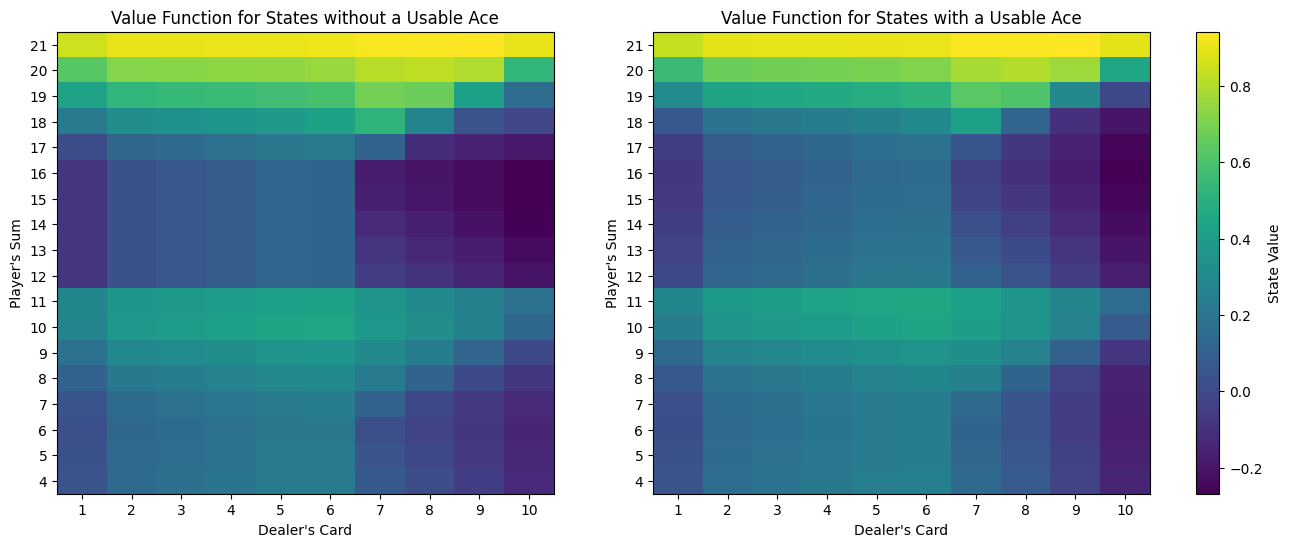

In [384]:
# PLOT VI VALUE FUNCTION, WITH & WITHOUT AN ACE
plot_value_function(V)

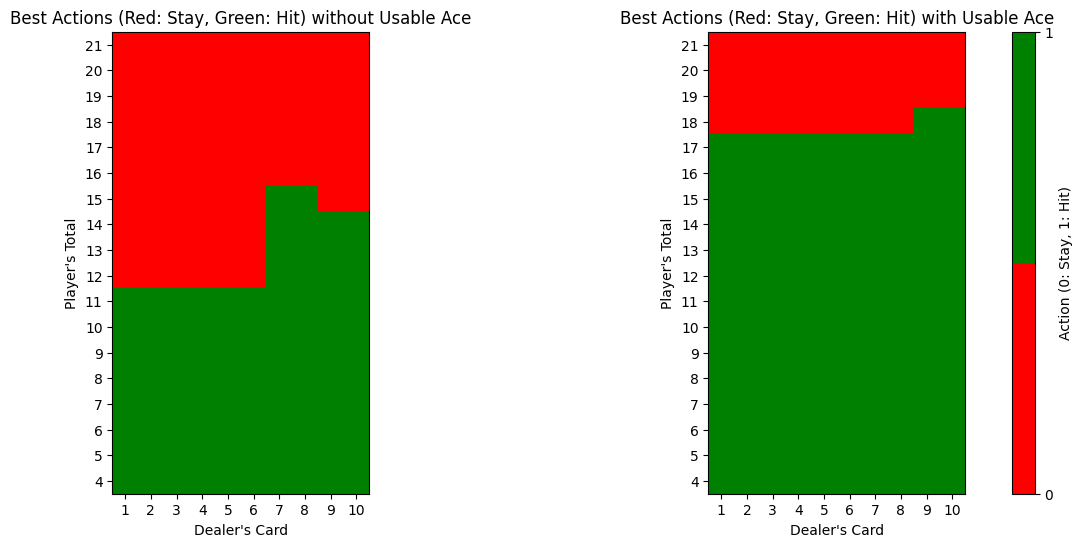

In [385]:
# PLOT VI POLICY, WITH & WITHOUT AN ACE
plot_policy(pi)

## Part 4: Q-Learning

Value iteration is a dynamic programming algorithm that requires a complete traversal of an MDP's state space. As such, it is not scalable to very large state spaces. An alternative is reinforcement learning (RL), which learns by simulating episodes in the environment.

$Q$-learning is a simple example of a RL algorithm. For as many simulated episodes as desired, an agent takes an action $a$ at a state $s$, receives a reward $r$ and transitions to a new state $s'$, and then updates its $Q$ value at the state-action pair $(s, a)$ based on the reward and the transition. Specifically, assuming learning rate $\alpha$,
$$
Q(s, a) \gets (1 - \alpha) Q(s, a) + \alpha [r + \max_{a' \in A} Q(s', a')]
$$

$Q$-learning is an off-policy learning algorithm, meaning it is not concerned with the rewards it accrues while learning. As a result, it can take arbitrary actions while learning, rather than focus on high-valued actions.

### Task:

Implement the `q_learning` function and compare the performance of this third policy with the other two you've already computed.

In [ ]:
def q_learning(mdp: Blackjack, num_episodes: int, alpha: float) -> Tuple[QTable, Dict[Tuple[BlackjackState, BlackjackAction], int]]:
    """
    Perform the Q-learning algorithm to learn a value function for Blackjack.
    
    Q-learning is a model-free reinforcement learning algorithm that learns
    the optimal action-value function Q*(s,a) through experience.
    
    The update rule is:
    Q(s,a) ← (1-α)Q(s,a) + α[r + max_a' Q(s',a')]
    
    This implementation uses ε-greedy exploration (purely random for simplicity).

    Args:
        mdp: A Blackjack MDP for environment interaction
        num_episodes: Number of episodes (games) to run for learning
        alpha: Learning rate controlling how quickly Q-values are updated

    Returns:
        Tuple containing:
        - Q: Q-table mapping (state, action) pairs to Q-values
        - observation_counts: Dictionary tracking visits to each (state, action) pair
    """
    Q: QTable = {}
    observation_counts = {} 
    actions = (0, 1)
    states = mdp.get_all_states()

    # Initialize Q-table and observation counts
    for state_action_pair in list(itertools.product(states, actions)):
        Q[state_action_pair] = 0.0
        observation_counts[state_action_pair] = 0 

    # TODO: Implement Q-Learning
    epsilon_start, epsilon_end= 1.0, 0.05
    eps_decay_steps = max(1, num_episodes)
    gamma = 1.0  

    for episode in range(num_episodes):
        epsilon = epsilon_start-(epsilon_start -epsilon_end)*(episode/eps_decay_steps)
        state = mdp.reset()
        done = False

        while not done:
            # eps greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(actions)
            else:
                q0 = Q[(state, 0)]
                q1 = Q[(state, 1)]
                action = 0 if q0 >= q1 else 1

            # take step
            next_state, reward, done= mdp.step(action)
            # next_state = normalize(next_state)
            # count visit
            observation_counts[(state, action)] += 1
            # if terminal, target=reward; else reward+max_a'Q(s',a')
            if done:
                target = reward
            else:
                q_next_0 =Q[(next_state, 0)]
                q_next_1 = Q[(next_state, 1)]
                target = reward + gamma * max(q_next_0, q_next_1)

            # Q-learning update
            Q[(state, action)] = (1-alpha)*Q[(state, action)]+alpha *target

            # move to next state
            state=next_state

    return Q, observation_counts

In [407]:
mdp = Blackjack(gym.make('Blackjack-v1', render_mode='rgb_array'))
Q, observation_counts = q_learning(mdp = mdp, num_episodes=100000, alpha=0.01)
pi = Q_table_to_policy(Q)

You should expect to achieve a win rate of about 43% with the policy learned from Q-learning.


In [408]:
_, _ = monte_carlo_simulation(mdp, pi, 100000)

Played 100000 episodes.
Win Rate: 43.09%
Average Reward: -0.05
Wins: 43094, Losses: 48015, Draws: 8891


Again, we provide you with code that enables you to visualizing the value function and the corresponding policy!

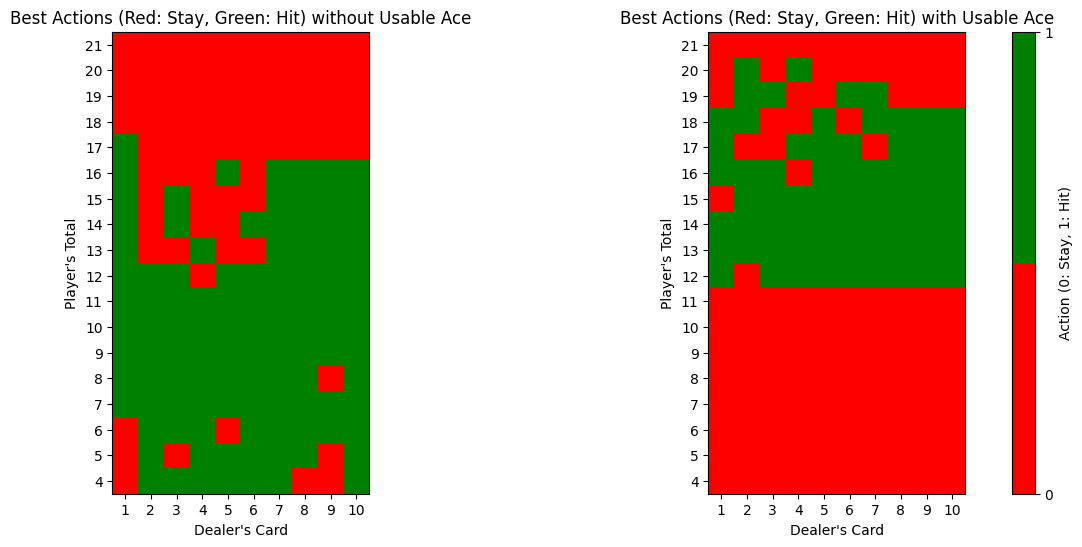

In [395]:
plot_policy(pi)

### Visualizing how often we visit each state in Q-Learning!

/Users/sparkles/Desktop/cs410/reinforcement-learning-ananyab123/utils.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


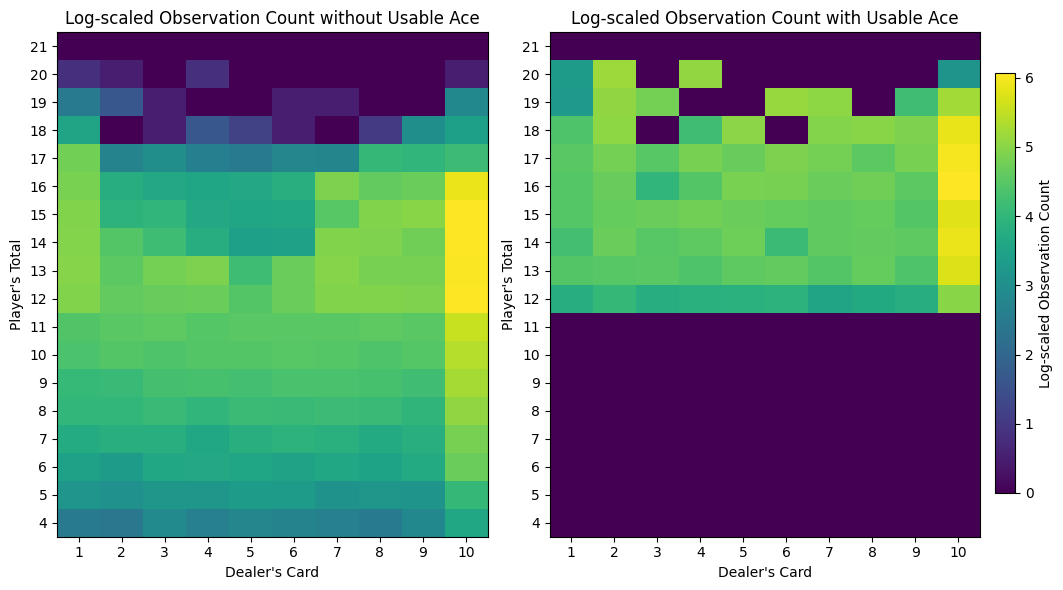

In [396]:
plot_observation_count(observation_counts)

/Users/sparkles/Desktop/cs410/reinforcement-learning-ananyab123/utils.py:246: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


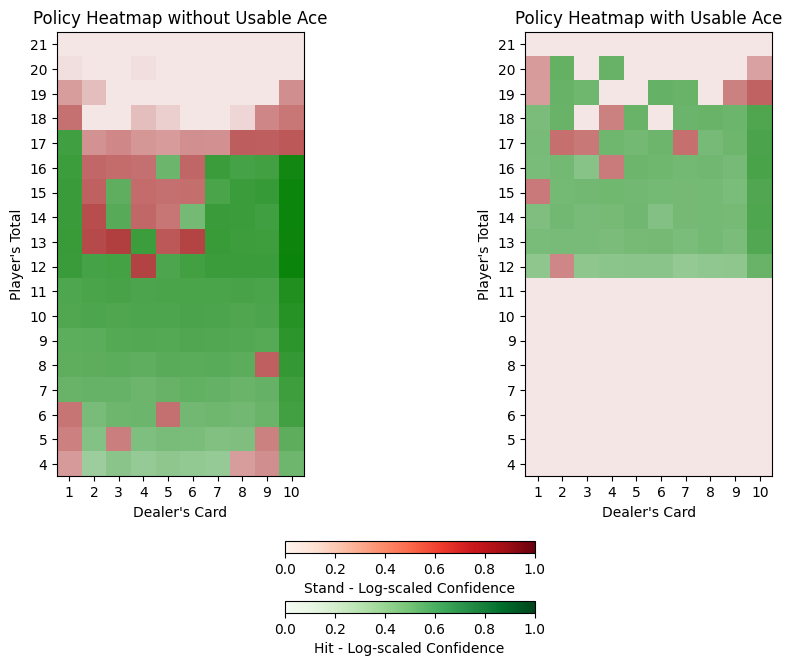

In [397]:
plot_policy_with_observation(observation_counts, pi)

## Part 5: Conceptual Questions

#### Blackjack in Casinos

The game of Blackjack you just solved is a relatively simple version of the game. It is *not* the version played in casinos. The game played in casinos has the following additional components:
1. Before any cards are dealt, the player decides how much money to bet.
2. A normal win pays out \$2 for every \$1 the player bets. Being dealt Blackjack (the player's total is 21 in exactly two cards) pays \$3 for every \$1 the player bets.
3. Players have two additional actions they may take. 
  1. Players may choose to "double", meaning they can double their bet. If a player doubles, she is only allowed to draw one additional card. 
  2. If dealt two cards of the same rank (e.g., two 5s), a player may choose to "split", in which case the player must again double her bet, as her cards are split into two separate hands that can be played separately.
4. Blackjack hands can be played sequentially. After one game finishes, another game begins without the cards played in the previous hand. After a certain number of hands are played, the decks are refreshed and shuffled. 

How would you modify our Blackjack MDP to capture all of this new complexity? In your README, describe the changes you would make to the states, actions, reward function, and transition function to model the Blackjack game played at casinos. For the transition function, you should discuss how the successor states might change given any modifications you make to your states, but you can leave out discussing transition probabilities.

What effect would your proposed changes to the Blackjack MDP have on the algorithms you implemented in this notebook (value iteration and Q-learning)? 

### Card Counting

The state representation you came up with in the previous question was probably quite complex; there is a lot of information to keep track of after all. If you could compute the optimal value function and play a perfect strategy, the player actually has an edge over the dealer. However, there's just far too many states for a human to remember how to play perfectly from every possible state. An alternative to keeping track of every card that has been played is to add a ["count"](https://en.wikipedia.org/wiki/Card_counting) value to your state. The "count" helps to keep track of how many large cards are left in the deck compared to the number of small cards. When a high card is played (10, J, Q, K, Ace), a the count is decreased by 1. When a low card is played (2, 3, 4, 5, 6), the count is increased by 1. When the count is high, the player has a higher chance of winning. The count can tell you the relative probability that a high card will be dealt next compared to a low card, so players no longer have to reason about *all* the previous cards that have been dealt or that are left in the deck; they just make decisions off of the player's total, dealer's total, and the count.

1. In your README, describe how you'd modify your MDP to model this card counting strategy. You can leave out discussion of transition probabilities in this question.
2. Does this problem still satisfy the Markov property? Do the probabilities of the next state depend only on the current state?
3. Given the exact probabilities of the transition function will be hard to calculate (e.g., what is the probability of drawing a 4 when the count is +2), which of the algorithms you implemented in this notebook would be easier to implement, Value Iteration of Q-Learning and why?
4. If you were able to find the optimal policy for the state representation using card counting and the full state representation of the previous question, how would you expect the quality of these policies to compare. If we ran `monte_carlo_simulation` on each policy, which would perform better?

## Wrapping up

Congratulations! You've completed Homework 8!

Please submit your Python code to the autograder. Use the following command to export the Python code from your Jupyter notebook.

```console
jupyter nbconvert --to python --RegexRemovePreprocessor.patterns="^%" blackjack.ipynb
```

If you get errors, make sure that you're working with the cs410_env and that `nbconvert` is installed. You can check this by running: 

```pip show nbconvert```

If it's not installed or outdated, try running 

```pip install --upgrade nbconvert```

and then running the jupyter command above again. 

Also, remember to submit a separate README, where you answer the conceptual questions.